<h1>Muti-factor Model<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Bundle-&amp;-Pipeline-Engine" data-toc-modified-id="Data-Bundle-&amp;-Pipeline-Engine-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Bundle &amp; Pipeline Engine</a></span></li><li><span><a href="#Statistical-Risk-Model" data-toc-modified-id="Statistical-Risk-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Statistical Risk Model</a></span><ul class="toc-item"><li><span><a href="#Fit-PCA" data-toc-modified-id="Fit-PCA-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fit PCA</a></span></li><li><span><a href="#Factor-Betas/Exposures---$\mathbf{B}$" data-toc-modified-id="Factor-Betas/Exposures---$\mathbf{B}$-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Factor Betas/Exposures - $\mathbf{B}$</a></span></li><li><span><a href="#Factor-Returns---$\mathbf{f}$" data-toc-modified-id="Factor-Returns---$\mathbf{f}$-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Factor Returns - $\mathbf{f}$</a></span></li><li><span><a href="#Factor-Covariance-Matrix---$\mathbf{F}$" data-toc-modified-id="Factor-Covariance-Matrix---$\mathbf{F}$-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Factor Covariance Matrix - $\mathbf{F}$</a></span></li><li><span><a href="#Idiosyncratic-Variance-Matrix---$\mathbf{S}$" data-toc-modified-id="Idiosyncratic-Variance-Matrix---$\mathbf{S}$-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Idiosyncratic Variance Matrix - $\mathbf{S}$</a></span></li><li><span><a href="#Idiosyncratic-Variance-Vector" data-toc-modified-id="Idiosyncratic-Variance-Vector-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Idiosyncratic Variance Vector</a></span></li><li><span><a href="#Portfolio-Risk" data-toc-modified-id="Portfolio-Risk-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Portfolio Risk</a></span></li></ul></li><li><span><a href="#Alpha-Factors" data-toc-modified-id="Alpha-Factors-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Alpha Factors</a></span><ul class="toc-item"><li><span><a href="#Adding-the-Factors-to-Pipeline" data-toc-modified-id="Adding-the-Factors-to-Pipeline-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Adding the Factors to Pipeline</a></span></li></ul></li><li><span><a href="#Alpha-Factor-Evaluation" data-toc-modified-id="Alpha-Factor-Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Alpha Factor Evaluation</a></span><ul class="toc-item"><li><span><a href="#Quantile-Analysis" data-toc-modified-id="Quantile-Analysis-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Quantile Analysis</a></span></li><li><span><a href="#Rank-IC" data-toc-modified-id="Rank-IC-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Rank IC</a></span></li><li><span><a href="#FRA-(Turnover-analysis)" data-toc-modified-id="FRA-(Turnover-analysis)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>FRA (Turnover analysis)</a></span></li><li><span><a href="#Sharpe-Ratio" data-toc-modified-id="Sharpe-Ratio-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Sharpe Ratio</a></span></li><li><span><a href="#Combined-Alpha-Vector" data-toc-modified-id="Combined-Alpha-Vector-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Combined Alpha Vector</a></span></li></ul></li><li><span><a href="#Portfolio-Optimization" data-toc-modified-id="Portfolio-Optimization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Portfolio Optimization</a></span><ul class="toc-item"><li><span><a href="#Approach-1.-Maximize-Alpha-with-Constraint-on-Risk" data-toc-modified-id="Approach-1.-Maximize-Alpha-with-Constraint-on-Risk-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Approach 1. Maximize Alpha with Constraint on Risk</a></span></li><li><span><a href="#Approach-2.-Optimize-with-Regularization-Parameter" data-toc-modified-id="Approach-2.-Optimize-with-Regularization-Parameter-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Approach 2. Optimize with Regularization Parameter</a></span></li><li><span><a href="#Approach-3.-Optimize-with-Strict-Factor-Constraints-&amp;-Target-Weighting" data-toc-modified-id="Approach-3.-Optimize-with-Strict-Factor-Constraints-&amp;-Target-Weighting-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Approach 3. Optimize with Strict Factor Constraints &amp; Target Weighting</a></span></li></ul></li></ul></div>

This project is a production ready prototype model that 
  - builds a cross-sectional statistical risk model using PCA, which is used to build a portfolio along with a number of momentum, mean reversion, and sentiment alpha factors
  - universe: US equities, top 500 in terms of dollar volume
  - evaluates the alpha factors, combining the promising signals into a single alpha vector
  - evaluates a few portfolio optimization approaches
  
**note:** uses end of day pricing data from Quotemedia and sector data from Sharadar, which could not be shared due to licensing restrictions

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [ ]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import putils

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

## Data Bundle & Pipeline Engine
---
Using `zipline` to handle the data, and build the pipeline engine

In [3]:
import os
from zipline.data import bundles

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..', 'data', 'eod')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], putils.EOD_BUNDLE_NAME)
bundles.register(putils.EOD_BUNDLE_NAME, ingest_func)

print('Data Registered')

Data Registered


In [4]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar


universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(putils.EOD_BUNDLE_NAME)
engine = putils.build_pipeline_engine(bundle_data, trading_calendar)

**Universe**

In [5]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers[:10]

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI])]

**Returns Data**

In [6]:
from zipline.data.data_portal import DataPortal


data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

`get_pricing` to get the pricing from the data portal

In [7]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

Five years of return data

In [8]:
five_year_returns = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0)

five_year_returns[:5]

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.00843652,0.01423027,0.02670202,0.00714639,0.00000000,0.00199434,0.00416541,0.00164769,-0.00712736,-0.00581846,...,-0.00183775,-0.00561865,0.00546091,-0.00404361,-0.01395259,0.00000000,0.01245693,-0.00018145,-0.01045802,0.00000000
2011-01-10 00:00:00+00:00,-0.00417428,0.00619534,0.00743543,0.01885158,0.00000000,-0.00571429,-0.00889600,-0.00885384,0.02871411,0.00292626,...,0.00094687,0.00781438,-0.00608100,0.01046585,0.00973303,0.00000000,0.00143979,0.00778351,-0.01794496,0.00000000
2011-01-11 00:00:00+00:00,-0.00188630,-0.04364361,-0.00592730,-0.00236744,0.00000000,0.00978303,-0.00206747,0.01371668,0.00060680,0.00875316,...,0.00131385,0.01017933,0.00744242,0.00735141,0.00611644,0.00000000,-0.00646974,0.03567570,0.00746728,0.00000000
2011-01-12 00:00:00+00:00,0.01725375,-0.00823708,0.01338721,0.00813289,0.00000000,-0.00597922,-0.00101061,0.02296913,0.01795027,0.00025710,...,0.00498609,0.01566621,0.01176334,0.02718194,0.00438630,0.00000000,0.00263106,0.01474083,-0.01190269,0.00000000
2011-01-13 00:00:00+00:00,-0.00455851,0.00095465,0.00303109,0.00365656,0.00000000,0.01492537,-0.00445119,-0.00040011,-0.00571905,-0.00501221,...,0.03049927,-0.00321668,0.00169383,0.00054651,-0.01823475,0.00000000,-0.00508430,-0.00466453,-0.00917796,0.00000000


In [9]:
five_year_returns[-5:]

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2015-12-29 00:00:00+00:00,0.01944279,0.00625637,0.01095726,0.01797599,0.01191076,0.00556913,0.01754180,0.01191401,0.01199575,0.01522413,...,0.01381318,0.00796362,0.00533553,0.01143615,0.01128297,0.00430697,0.00541538,0.00723499,0.00617376,0.00899694
2015-12-30 00:00:00+00:00,-0.00638405,-0.01608535,-0.00525423,-0.01305616,0.00590373,0.00239063,-0.01201673,0.00512422,-0.00052449,-0.01325558,...,-0.01461683,-0.00706442,-0.01326109,-0.00807866,0.00184720,-0.00618212,-0.00578080,-0.00292090,-0.01223479,-0.00145450
2015-12-31 00:00:00+00:00,-0.01243206,-0.01053186,-0.00587919,-0.01919944,-0.00937219,-0.01248112,-0.00795266,-0.01284442,-0.01406381,-0.02174525,...,-0.01605213,-0.01817456,-0.00205030,-0.00911914,-0.00837082,-0.01003138,-0.01029925,0.00117577,-0.00621188,-0.00705088
2016-01-04 00:00:00+00:00,-0.02828157,-0.03398810,0.01149418,0.00085542,-0.02751240,-0.01774070,-0.04406668,-0.02555086,-0.02097083,-0.01591868,...,-0.02476714,-0.02492212,-0.00627612,-0.03271090,-0.03105128,-0.01151995,-0.01148918,-0.00760365,-0.02161389,-0.01356408
2016-01-05 00:00:00+00:00,0.00405845,-0.00954098,-0.00683002,-0.02505441,-0.00416936,0.01462920,-0.00024665,0.00520704,0.00402305,-0.00734750,...,0.00209794,0.01486318,0.00851070,0.02039022,-0.00195732,-0.00028634,-0.00249493,0.02081954,-0.01085325,0.01564723


## Statistical Risk Model
---

$$
\textbf{r} = \textbf{B}\textbf{f} + \textbf{s}
$$

### Fit PCA

In [10]:
from sklearn.decomposition import PCA


def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fits PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)
    return pca

In [11]:
num_factor_exposures = 20
pca = fit_pca(five_year_returns, num_factor_exposures, 'full')

PCA's pct of variance explained by each factor:

<Container object of 20 artists>

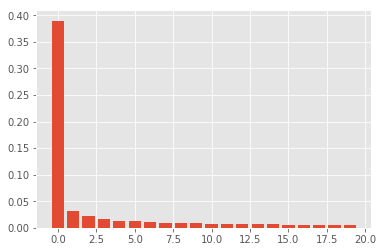

In [12]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

### Factor Betas/Exposures - $\mathbf{B}$

Reduced form factor betas

In [13]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Returns factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    data = pca.components_.T 
    df = pd.DataFrame(data=data, index=factor_beta_indices, columns=factor_beta_columns)
    
    return df

In [14]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, five_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas'][:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Equity(0 [A]),-0.04316847,0.01955111,-0.00993375,0.01054038,-0.01819821,0.01074517,0.00112915,0.03973914,-0.01380519,0.01273651,-0.02384028,-0.00141663,0.02099338,0.03460997,-0.03048936,0.03360635,-0.01142920,-0.01174265,0.00526925,-0.00535269
Equity(1 [AAL]),-0.05874471,0.19637679,0.07868756,0.08209582,0.34847826,-0.13808246,0.07129285,0.10524788,-0.04588957,-0.08547793,0.00328328,0.10534284,0.06721603,-0.04405955,-0.02231617,0.01726309,-0.03310836,0.01398085,-0.04680674,-0.01599057
Equity(2 [AAP]),-0.03433256,0.03451503,0.01133839,-0.02543666,-0.00817211,-0.01318319,-0.06095238,0.00654915,-0.03265404,-0.01351522,0.02896685,0.03836520,-0.04960451,-0.00524576,-0.02196994,0.02976718,-0.01163585,0.05143999,0.05716915,0.08414961
Equity(3 [AAPL]),-0.03409988,-0.00139319,0.03946700,-0.01721303,-0.03046983,-0.01757067,0.02325117,0.01142987,-0.02656849,-0.00771904,0.02686350,0.00731877,0.00481832,0.01288623,0.05256513,-0.07344470,-0.03179158,0.09079374,-0.01118851,0.04291373
Equity(4 [ABBV]),-0.01803099,0.02568151,0.00435183,-0.07078179,0.01319937,0.05427710,-0.01567842,0.04046172,-0.01245487,-0.03515086,-0.05132433,-0.04041614,-0.05120320,-0.01858166,-0.01126857,-0.04200714,0.01588559,0.04598554,0.01599288,0.06587978


### Factor Returns - $\mathbf{f}$

Reduced form factor returns

In [15]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Returns the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    df = pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    return df

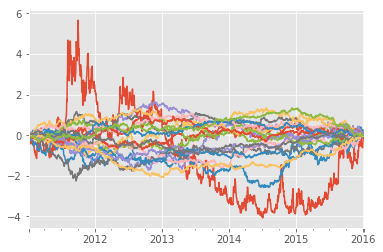

In [16]:
risk_model['factor_returns'] = factor_returns(
    pca,
    five_year_returns,
    five_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None)

### Factor Covariance Matrix - $\mathbf{F}$

Annualized factor covariance matrix: 

$$
\textbf{F} = \frac{1}{T -1}\textbf{f}\textbf{f}^T
$$

In [17]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Returns annualized factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """
    
    return np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)

In [18]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix'][0]

array([ 14.01830425,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

### Idiosyncratic Variance Matrix - $\mathbf{S}$

Annualized idiosyncratic variance matrix, covariance matrix of residuals $\mathbf{s}$, and off-diagonal elements set to zero where:

$$
\textbf{s} = \textbf{r} - \textbf{B}\textbf{f}
$$

In [19]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Returns the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    
    common_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    residuals = returns - common_returns
    
    df = pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    return df

In [20]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix'][:5]

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
Equity(0 [A]),0.02272535,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(1 [AAL]),0.00000000,0.05190083,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(2 [AAP]),0.00000000,0.00000000,0.05431181,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(3 [AAPL]),0.00000000,0.00000000,0.00000000,0.04801884,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(4 [ABBV]),0.00000000,0.00000000,0.00000000,0.00000000,0.03040361,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


### Idiosyncratic Variance Vector

In [21]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Returns the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
    
    df = pd.DataFrame(np.diag(idiosyncratic_var_matrix.values), index=returns.columns)
    
    return df

In [22]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector'][:5]

,0
Equity(0 [A]),0.02272535
Equity(1 [AAL]),0.05190083
Equity(2 [AAP]),0.05431181
Equity(3 [AAPL]),0.04801884
Equity(4 [ABBV]),0.03040361


### Portfolio Risk

$\sigma_p =  \sqrt{X^{T}(BFB^{T} + S)X}$
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [23]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Returns predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    port_var = np.dot(np.dot(weights.T, (np.dot(np.dot(factor_betas, factor_cov_matrix), factor_betas.T) + idiosyncratic_var_matrix)), weights)
    port_risk = np.sqrt(port_var[0][0])
    
    return port_risk

Equal weighted portfolio risk:

In [24]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.16094824687040474

## Alpha Factors
---

**1. 1 Yr Momentum**

"Higher past 12-month (252 days) returns are proportional to future return."

In [25]:
from zipline.pipeline.factors import Returns

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

**2. Mean Reversion - 5 day sector neutral**

"Short-term outperformers(underperformers) compared to their sector will revert."

In [26]:
def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generates the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """
    factor = Returns(window_length=window_length, mask=universe).demean(groupby=sector).rank().zscore()
    
    return factor*-1

**Note:** *Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, went back 2 extra days*

In [27]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
sector = putils.Sector()
window_length = 5

pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral(window_length, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)[:5]

Mean_Reversion_5Day_Sector_Neutral
2014-01-03 00:00:00+00:00 Equity(0 [A])                             0.85326482
                          Equity(1 [AAL])                           1.62630815
                          Equity(2 [AAP])                           0.64906469
                          Equity(3 [AAPL])                          1.40752230
                          Equity(4 [ABBV])                          1.45857233

**3. Mean Reversion - 5 day sector neutral - smoothed**

In [28]:
from zipline.pipeline.factors import SimpleMovingAverage

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generates the mean reversion 5 day sector neutral smoothed factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral smoothed factor
    """
    factor = mean_reversion_5day_sector_neutral(window_length, universe, sector)
    
    factor_smoothed = SimpleMovingAverage(inputs=[factor], window_length=window_length).rank().zscore()

    return factor_smoothed

In [29]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)[:5]

Mean_Reversion_5Day_Sector_Neutral_Smoothed
2014-01-03 00:00:00+00:00 Equity(0 [A])                                      1.11580784
                          Equity(1 [AAL])                                    1.72840822
                          Equity(2 [AAP])                                    1.34188655
                          Equity(3 [AAPL])                                   0.91160771
                          Equity(4 [ABBV])                                   0.96265774

**4. Overnight Sentiment** using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010)
 - The finding discussed in detail is that Trailing 5-day Overnight returns exhibit both momentum (persistence) and mean-reversion. Stocks with high weekly overnight returns outperform for up to 4 weeks. Then exhibit mean-reversion.


In [30]:
from zipline.pipeline.data import USEquityPricing


class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]

        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

        
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    return TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

**5. Overnight Sentiment Smoothed**

In [31]:
def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

### Adding the Factors to Pipeline

In [32]:
universe = AverageDollarVolume(window_length=120).top(500)
sector = putils.Sector()

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors.head()

Mean_Reversion_5Day_Sector_Neutral  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                             0.85326482   
                          Equity(1 [AAL])                           1.62630815   
                          Equity(2 [AAP])                           0.64906469   
                          Equity(3 [AAPL])                          1.40752230   
                          Equity(4 [ABBV])                          1.45857233   

                                            Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                                      1.11580784   
                          Equity(1 [AAL])                                    1.72840822   
                          Equity(2 [AAP])                                    1.34188655   
                          Equity(3 [AAPL])                                   0.91160771   
                          Equity(4 [ABBV])                                   0.96265774   

                                            Momentum_1YR  Overnight_Sentiment  \
2014-01-03 00:00:00+00:00 Equity(0 [A])       1.49939067           0.70659131   
                          Equity(1 [AAL])     1.60279693          -1.70668978   
                          Equity(2 [AAP])     0.37669421           0.03261191   
                          Equity(3 [AAPL])   -1.48461835          -1.67770142   
                          Equity(4 [ABBV])    0.91588396          -1.47478289   

                                            Overnight_Sentiment_Smoothed  
2014-01-03 00:00:00+00:00 Equity(0 [A])                       1.11242837  
                          Equity(1 [AAL])                    -1.72843105  
                          Equity(2 [AAP])                    -0.62687332  
                          Equity(3 [AAPL])                    0.53990823  
                          Equity(4 [ABBV])                   -0.06160027

## Alpha Factor Evaluation
---

Pricing Data

In [33]:
import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date)

Many of the alphalens functions require the indices to be aligned and converted to unix timestamp

In [35]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 1.2% entries from factor data: 1.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.2% entries from factor data: 1.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [49]:
clean_factor_data['Momentum_1YR'][:5]

1D      factor  \
date                      asset                                      
2014-01-06 00:00:00+00:00 Equity(0 [A])     0.01516805  1.52154916   
                          Equity(1 [AAL])  -0.00464920  1.57325228   
                          Equity(2 [AAP])   0.01234256  0.59827904   
                          Equity(3 [AAPL]) -0.00716334 -1.46984603   
                          Equity(4 [ABBV])  0.00199754  1.00451789   

                                            factor_quantile  
date                      asset                              
2014-01-06 00:00:00+00:00 Equity(0 [A])                   5  
                          Equity(1 [AAL])                 5  
                          Equity(2 [AAP])                 4  
                          Equity(3 [AAPL])                1  
                          Equity(4 [ABBV])                4

In [51]:
unixt_factor_data['Mean_Reversion_5Day_Sector_Neutral'][:5]

1D      factor  factor_quantile
date                asset                                                    
1388966400.00000000 Equity(0 [A])     0.01516805 -0.82409337                2
                    Equity(1 [AAL])  -0.00464920 -1.70652963                1
                    Equity(2 [AAP])   0.01234256 -1.56796526                1
                    Equity(3 [AAPL]) -0.00716334  1.70652963                5
                    Equity(4 [ABBV])  0.00199754  0.19690727                3

### Quantile Analysis

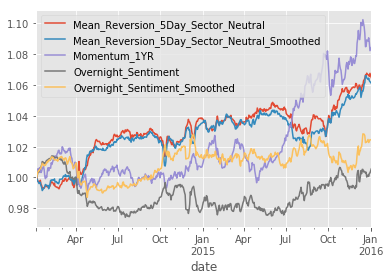

In [36]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot()

Basis Points Per Day per Quantile

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fd2f20320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1fd2de6160>]], dtype=object)

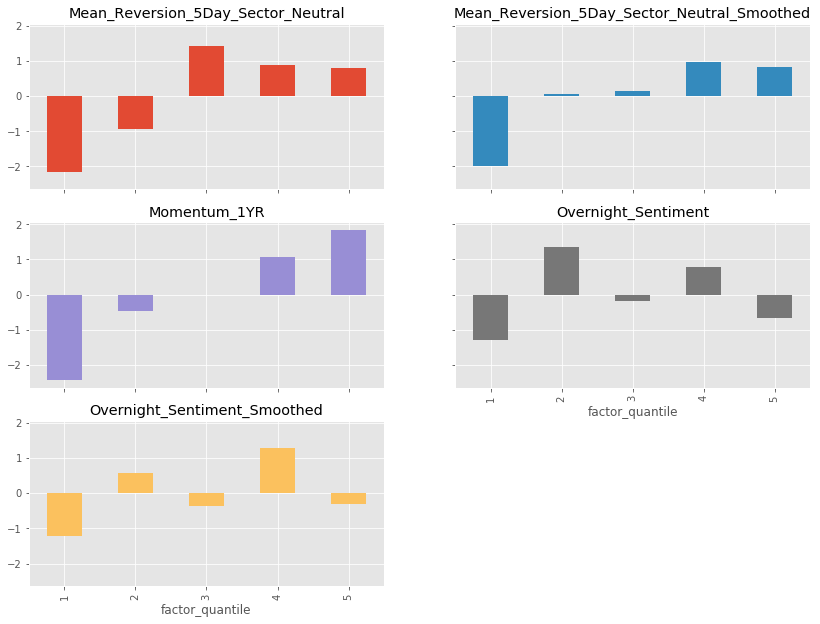

In [46]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

- None of these alphas are **strictly monotonic**
- The majority of the return is coming from the **short side**  - availability and cost concerns
- Return spreads (Q1 - Q5) hovers around 3 basis points (0.03%) *before all transaction costs, shorting costs, etc.*. Assuming 252 days in a year, that's 7.56% return annualized.

### Rank IC

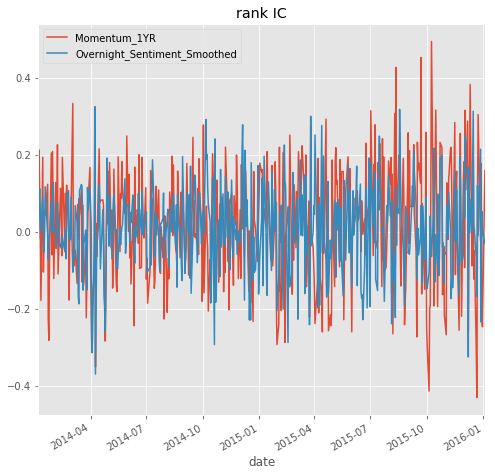

In [57]:
factor_ic = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    factor_ic[factor] = al.performance.factor_information_coefficient(factor_data).iloc[:, 0]
    
factor_ic[['Momentum_1YR', 'Overnight_Sentiment_Smoothed']].plot(title="rank IC", figsize=(8, 8))

### FRA (Turnover analysis)

Stability of alphas over time

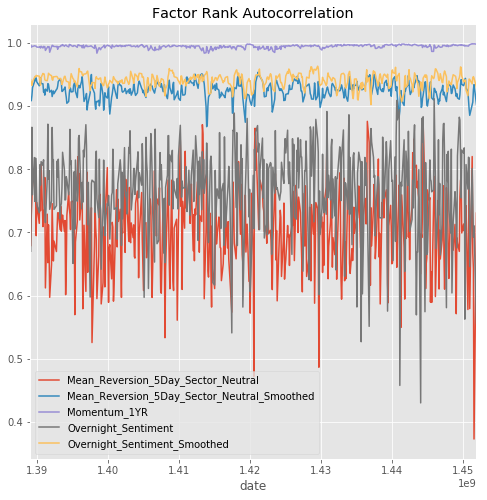

In [59]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation", figsize=(8, 8))

### Sharpe Ratio

In [61]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Returns the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    
    sharpe = pd.Series(factor_returns.mean()*annualization_factor/factor_returns.std())
    
    return sharpe

In [62]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Mean_Reversion_5Day_Sector_Neutral            1.37000000
Mean_Reversion_5Day_Sector_Neutral_Smoothed   1.27000000
Momentum_1YR                                  1.13000000
Overnight_Sentiment                           0.12000000
Overnight_Sentiment_Smoothed                  0.45000000
dtype: float64

### Combined Alpha Vector

Simple average of the alpha scores across `Mean_Reversion_5Day_Sector_Neutral_Smoothed`, `Momentum_1YR`, `Overnight_Sentiment_Smoothed`

In [63]:
selected_factors = all_factors.columns[[1, 2, 4]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
alpha_vector.head()

Selected Factors: Mean_Reversion_5Day_Sector_Neutral_Smoothed, Momentum_1YR, Overnight_Sentiment_Smoothed


,alpha_vector
Equity(0 [A]),-0.58642457
Equity(1 [AAL]),-0.45333845
Equity(2 [AAP]),-0.69993898
Equity(3 [AAPL]),-0.06790952
Equity(4 [ABBV]),-1.21617871


## Portfolio Optimization
---

### Approach 1. Maximize Alpha with Constraint on Risk

$$
\text { objective: minimize }-\alpha^{T} \mathbf{x}, \text { with a constraint on risk: }-\mathbf{x}^{T}\left(\mathbf{B}^{T} \mathbf{F} \mathbf{B}+\mathbf{S}\right) \mathbf{x}\leq risk_{\text{cap}}^2
$$
 - $\alpha$: subset of factors that is the alpha factors
 - $\mathbf{x}$: portfolio weights

Other constraints:
 - $ B^T * \mathbf{x} \preceq factor_{\text{max}} $ - max factor exposure
 - $ B^T * \mathbf{x}  \succeq factor_{\text{min}}$ - min factor exposure
 - $ \mathbf{x}^T\mathbb{1} = 0 $ - market neutral
 - $ \|\mathbf{x} \|_1 \leq 1 $ - leverage constraint
 - $ \mathbf{x}  \succeq weights_{\text{min}} $ - min individual holding weight
 - $ \mathbf{x} \preceq weights_{\text{max}} $ - max individual holding weight

In [65]:
class OptimalHoldings():
    def _get_obj(self, weights, alpha_vector):
        """
        Returns the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        obj = cvx.Minimize(-alpha_vector.values.flatten()*weights)
        
        return obj
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Returns the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        constraints = [
            risk <= self.risk_cap**2, 
            factor_betas.T*weights <= self.factor_max, 
            factor_betas.T*weights >= self.factor_min,
            sum(weights) == 0.0,
            sum(cvx.abs(weights)) <= 1.0,
            weights >= self.weights_min, 
            weights <= self.weights_max
        ]
        
        return constraints

    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)
    
    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

Issue here portfolio is not diversified at all

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


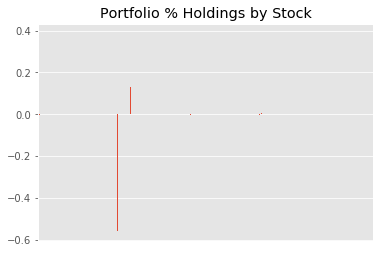

In [66]:
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

In [94]:
from scipy.stats.stats import pearsonr
def transfer_coefficient(alpha_vector, optimized_weights):
   
    transfer_coefficient, pvalue = pearsonr(alpha_vector, optimized_weights)
    return transfer_coefficient

transfer_coefficient(alpha_vector.values, optimal_weights.values)

print("The transfer coefficient is {}".format(transfer_coefficient(alpha_vector.values, optimal_weights.values)[0])) 

The transfer coefficient is 0.19751449952642713


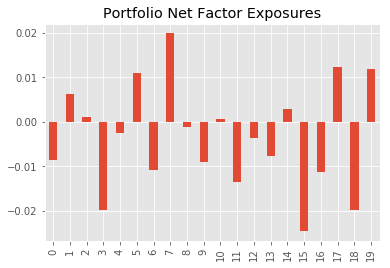

In [75]:
putils.get_factor_exposures(risk_model['factor_betas'], optimal_weights).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

### Approach 2. Optimize with Regularization Parameter

$\lambda$ enforces diversification

$$
\text { objective: minimize }-\alpha^{T} \mathbf{x}+\lambda\|\mathbf{x}\|_{2}, \text { with a constraint on risk: }-\mathbf{x}^{T}\left(\mathbf{B}^{T} \mathbf{F} \mathbf{B}+\mathbf{S}\right) \mathbf{x} \leq risk_{\text{cap}}^2
$$

In [72]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Returns the objective function with regularization

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        obj = cvx.Minimize(-alpha_vector.values.flatten()*weights + self.lambda_reg*cvx.norm(weights, p=2, axis=None))
        
        return obj

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

Achieves better diversification

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


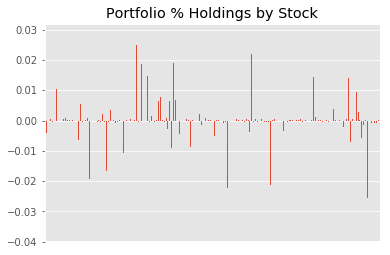

In [73]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

In [95]:
print("The transfer coefficient is {}".format(transfer_coefficient(alpha_vector.values, optimal_weights_1.values)[0])) 

The transfer coefficient is 0.7680218093459014


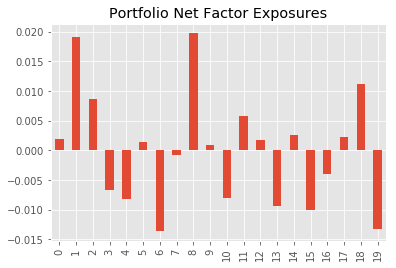

In [74]:
putils.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

### Approach 3. Optimize with Strict Factor Constraints & Target Weighting

Common alternative to regularization if that doesn't produce satisfactory results

$$
\text { objective: minimize }\left\|\mathbf{x}-\mathbf{x}^{*}\right\|, \text { with a constraint on risk: }-\mathbf{x}^{T}\left(\mathbf{B}^{T} \mathbf{F} \mathbf{B}+\mathbf{S}\right) \mathbf{x} \leq risk_{\text{cap}}^2
$$

where $\mathbf{x}^{*}$ is target weighting

In [77]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        target = (alpha_vector-alpha_vector.mean())/alpha_vector.abs().sum()
        target = target.values.flatten()
        
        obj = cvx.Minimize(cvx.norm(weights-target, p=2, axis=None))
        
        return obj

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


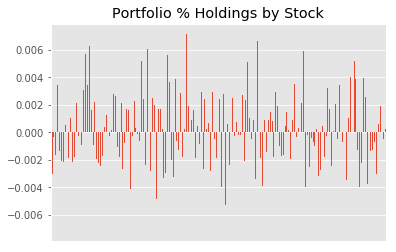

In [78]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

transfer coefficient will be naturally high since the target weight is the alpha vector itself

In [97]:
print("The transfer coefficient is {}".format(transfer_coefficient(alpha_vector.values, optimal_weights_2.values)[0])) 

The transfer coefficient is 0.9998090046606518


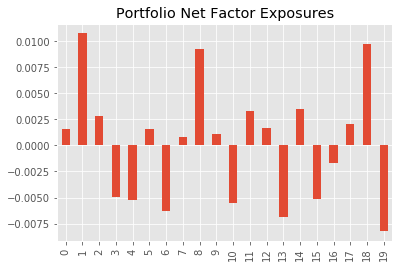

In [79]:
putils.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)